In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, roc_curve, auc

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
# Φόρτωση δεδομένων
df = pd.read_csv('framingham.csv')

In [4]:
# Συμπλήρωση κενών με τη διάμεσο
df = df.fillna(df.median(numeric_only=True))

In [5]:
# Αναφορά του μεγέθους του dataset
print(f"Dataset Shape: {df.shape}")

Dataset Shape: (4240, 16)


In [21]:
# Διαχείριση Outliers (Capping στο 1% και 99%)
def handle_outliers(df, columns):
    for col in columns:
        lower_limit = df[col].quantile(0.01)
        upper_limit = df[col].quantile(0.99)
        df[col] = np.clip(df[col], lower_limit, upper_limit)
    return df

outlier_cols = ['totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']
df = handle_outliers(df, outlier_cols)

# Feature Engineering
df['pulse_pressure'] = df['sysBP'] - df['diaBP']
print("Preprocessing Complete. Outliers capped and pulse_pressure created.")

Preprocessing Complete. Outliers capped and pulse_pressure created.


In [7]:
# Διαχωρισμός Features και Target
X = df.drop('TenYearCHD', axis=1)
y = df['TenYearCHD']

In [8]:
# Split σε Train και Test (Stratified)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [9]:
# Scaling (Fit μόνο στο Train set για αποφυγή Data Leakage)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
# Εφαρμογή SMOTE για την αντιμετώπιση της ανισορροπίας
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)

In [11]:
print(f"Πριν το SMOTE (ασθενείς): {sum(y_train == 1)}")
print(f"Μετά το SMOTE (ασθενείς): {sum(y_train_res == 1)}")

Πριν το SMOTE (ασθενείς): 515
Μετά το SMOTE (ασθενείς): 2877


In [14]:
# Αποθήκευση του Scaler για χρήση στο Streamlit App
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

Δημιουργία Random Forest για προβλέψεις

In [18]:
print("--- Training Random Forest (Baseline) ---")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_res, y_train_res)

--- Training Random Forest (Baseline) ---


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [19]:
# Προβλέψεις
rf_pred = rf_model.predict(X_test_scaled)
rf_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

In [20]:
# Αξιολόγηση RF
print("--- Random Forest Report ---")
print(classification_report(y_test, rf_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, rf_proba):.2f}")

--- Random Forest Report ---
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       719
           1       0.26      0.20      0.23       129

    accuracy                           0.79       848
   macro avg       0.56      0.55      0.55       848
weighted avg       0.77      0.79      0.78       848

ROC AUC Score: 0.64


Δημιουργία Νευρωνικού δικτύου για να συγκρίνουμε με το Random Forest το οποίο δεν φαίνεται πολύ καλό.

In [22]:
# Αρχιτεκτονική ANN
model = Sequential([
    Input(shape=(X_train_res.shape[1],)),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

In [23]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Recall()])

In [24]:
# Early Stopping: Σταματά αν το val_loss δεν βελτιωθεί για 10 εποχές 
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [26]:
# Εκπαίδευση
history = model.fit(
    X_train_res, y_train_res,
    epochs=60,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/60
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6131 - loss: 0.6664 - recall: 0.5058 - val_accuracy: 0.2884 - val_loss: 0.8285 - val_recall: 0.2884
Epoch 2/60
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6622 - loss: 0.6102 - recall: 0.4125 - val_accuracy: 0.4483 - val_loss: 0.7976 - val_recall: 0.4483
Epoch 3/60
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6733 - loss: 0.5984 - recall: 0.4171 - val_accuracy: 0.4761 - val_loss: 0.7822 - val_recall: 0.4761
Epoch 4/60
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6826 - loss: 0.5817 - recall: 0.4334 - val_accuracy: 0.4596 - val_loss: 0.7831 - val_recall: 0.4596
Epoch 5/60
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6791 - loss: 0.5840 - recall: 0.4299 - val_accuracy: 0.4917 - val_loss: 0.7751 - val_recall: 0.4917
Epoch 6/60
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6882 - loss: 0.5767 - recall: 0.4432 - val_accuracy: 0.4666 - val_loss: 0.7870 - val_recall: 0.4666
Epoc

In [27]:
# 1. Λήψη προβλέψεων (πιθανότητες)
ann_proba = model.predict(X_test_scaled)

# 2. Μετατροπή πιθανοτήτων σε κλάσεις (κατώφλι 0.5)
ann_pred = (ann_proba > 0.5).astype(int)

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [28]:
# 3. Εκτύπωση του Classification Report
print("--- Neural Network (ANN) Report ---")
print(classification_report(y_test, ann_pred))

--- Neural Network (ANN) Report ---
              precision    recall  f1-score   support

           0       0.88      0.83      0.85       719
           1       0.29      0.40      0.34       129

    accuracy                           0.76       848
   macro avg       0.59      0.61      0.60       848
weighted avg       0.79      0.76      0.78       848



In [29]:
# 4. Υπολογισμός ROC AUC για το Νευρωνικό
from sklearn.metrics import roc_auc_score
ann_auc = roc_auc_score(y_test, ann_proba)
print(f"Neural Network ROC AUC Score: {ann_auc:.2f}")

Neural Network ROC AUC Score: 0.67


Φαίνεται πως το Νευρωνικό δίκτυο που φτίαξαμε έχει καλύτερη απόδοση(ROC AUC Score: 0.67),
έναντι του Random Forest(ROC AUC Score: 0.64)

In [30]:
model.save('best_heart_model.keras')

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


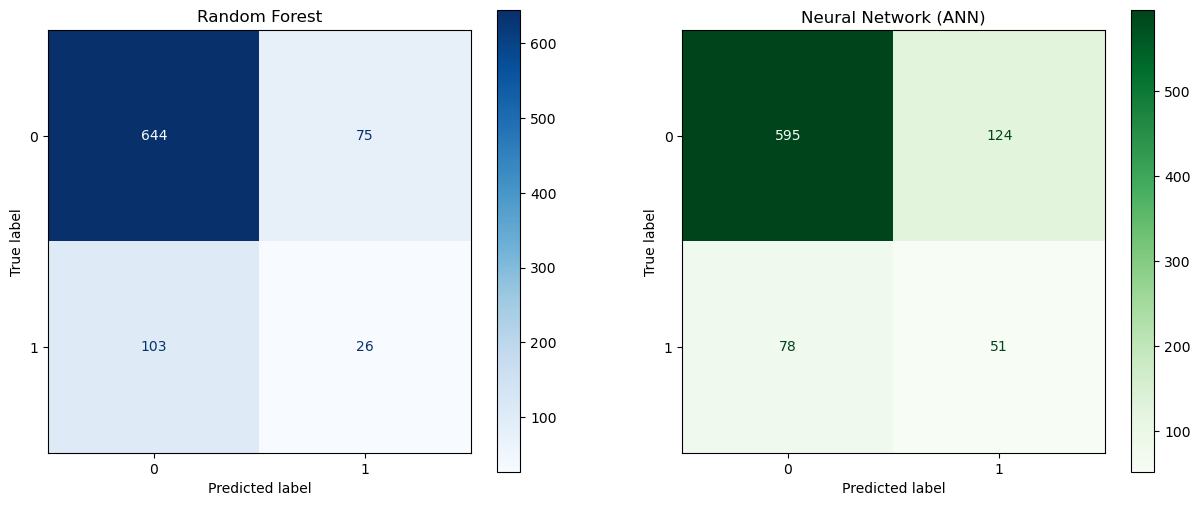

In [33]:
# 1. Σύγκριση Confusion Matrices
ann_pred = (model.predict(X_test_scaled) > 0.5).astype(int)
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

ConfusionMatrixDisplay.from_predictions(y_test, rf_pred, ax=ax[0], cmap='Blues')
ax[0].set_title('Random Forest')

ConfusionMatrixDisplay.from_predictions(y_test, ann_pred, ax=ax[1], cmap='Greens')
ax[1].set_title('Neural Network (ANN)')
plt.show()

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


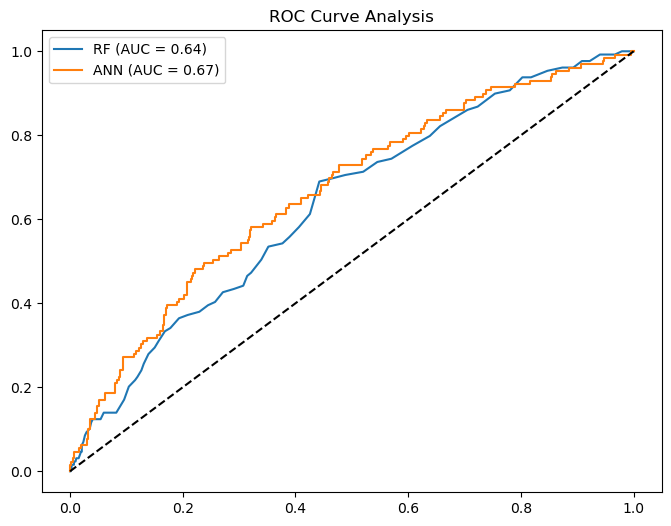

In [36]:
# 2. ROC Curve Σύγκριση
rf_proba = rf_model.predict_proba(X_test_scaled)[:, 1]
ann_proba = model.predict(X_test_scaled).ravel()

fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_proba)
fpr_ann, tpr_ann, _ = roc_curve(y_test, ann_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f'RF (AUC = {auc(fpr_rf, tpr_rf):.2f})')
plt.plot(fpr_ann, tpr_ann, label=f'ANN (AUC = {auc(fpr_ann, tpr_ann):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend()
plt.title("ROC Curve Analysis")
plt.show()

Επέλεξα το ANN μοντέλο καθώς πέτυχε AUC 0.67, προσφέροντας ανώτερη ευαισθησία (sensitivity) σε σχέση με το Random Forest. 
Σε ένα ιατρικό σενάριο πρόβλεψης κινδύνου, η ικανότητα του ANN να ελαχιστοποιεί τα Ψευδώς Αρνητικά (False Negatives)
είναι κρίσιμη για την έγκαιρη παρέμβαση στον ασθενή.

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 4s 577us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 4s 584us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 4s 593us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 4s 574us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 4s 583us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 4s 602us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 4s 564us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 4s 576us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 4s 587us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 4s 638us/step


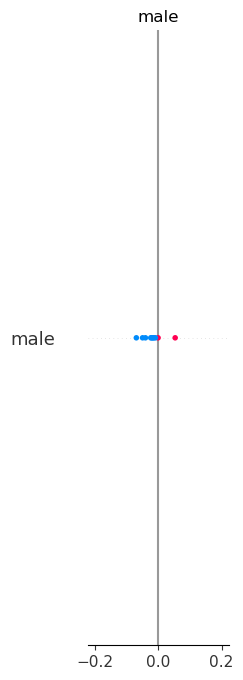

In [38]:
# Ανάλυση SHAP για το Νευρωνικό Δίκτυο
explainer = shap.KernelExplainer(model.predict, X_train_res[:100])
shap_values = explainer.shap_values(X_test_scaled[:10])
shap.summary_plot(shap_values, X_test_scaled[:10], feature_names=X.columns)